In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.optimize

from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam

from tqdm.autonotebook import tqdm

In [14]:
class Burgers(Model):

    def __init__(self):
        super(Burgers, self).__init__()

        self.h1 = Dense(20, activation="tanh")
        self.h2 = Dense(20, activation="tanh")
        self.h3 = Dense(20, activation="tanh")
        self.h4 = Dense(20, activation="tanh")
        self.h5 = Dense(20, activation="tanh")
        self.h6 = Dense(20, activation="tanh")
        self.u = Dense(1, activation="linear")

    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        x = self.h6(x)
        out = self.u(x)
        return out


class PINN:
    def __init__(self):
        self.lr = 0.001
        self.opt = Adam(self.lr)
        self.model = Burgers()
        self.model.build(input_shape=(None, 2))

    @tf.function
    def physics_net(self, xt):
        x = xt[:, 0:1]
        t = xt[:, 1:2]
        xt_t = tf.concat([x, t], axis=1)
        u = self.model(xt_t)
        u_x = tf.gradient(u, x)
        u_xx = tf.gradient(u_x, x)
        u_t = tf.gradient(u, t)

        f = u_t + u * u_x - (0.01 / tf.constant(np.pi)) * u_xx
        return f

    def save_weights(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        self.model.save_weights(path + "burgers.h5")

    def load_weights(self, path):
        self.model.load_weights(path + "burgers.h5")

    def learn(self, xt_col, xt_bnd, tu_bnd):
        with tf.GradientTape() as tape:
            f = self.physics_net(xt_col)
            loss_col = tf.reduce_mean(tf.square(f))

            tu_bnd_hat = self.model(xt_bnd)
            loss_bnd = tf.reduce_mean(tf.square(tu_bnd - tu_bnd_hat))

            loss = loss_col + loss_bnd

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss

    def predict(self, xt):
        return self.model(xt)

    def train(self, max_num):
        # initial and boundary condition
        x_data = np.linspace(-1, 1, 500)
        t_data = np.linspace(0, 1, 500)
        xt_bnd_data = []
        tu_bnd_data = []

        for x in x_data:
            xt_bnd_data.append([x, 0])
            tu_bnd_data.append([-np.sin(np.pi * x)])

        for t in t_data:
            xt_bnd_data.append([1, t])
            tu_bnd_data.append([0])
            xt_bnd_data.append([-1, t])
            tu_bnd_data.append([0])

        xt_bnd_data = np.array(xt_bnd_data)
        tu_bnd_data = np.array(tu_bnd_data)

        # collocation points
        t_col_data = np.random.uniform(0, 1, [20000, 1])
        x_col_data = np.random.uniform(-1, 1, [20000, 1])
        xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1) # shape: [20000, 2]
        xt_col_data = np.concatenate([xt_col_data, xt_bnd_data], axis=0) # [20000, 2]

        train_loss_history = []

        for iter in tqdm(range(int(max_num))):
            loss = self.learn(
                tf.convert_to_tensor(xt_col_data, dtype=tf.float32),
                tf.convert_to_tensor(xt_bnd_data, dtype=tf.float32),
                tf.convert_to_tensor(tu_bnd_data, dtype=tf.float32),
            )
            train_loss_history.append([iter, loss])

            if iter % 100 == 0:
                print("Iter: %d, Loss: %.4e" % (iter, loss))

        self.save_weights("./save_weights/")

        np.savetxt("./save_weights/train_loss_history.txt", train_loss_history)
        train_loss_history = np.array(train_loss_history)

        plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Train Loss History")
        plt.grid()
        plt.show()

Iter: 0, Loss: 4.4672e-01
Iter: 100, Loss: 9.6838e-02
Iter: 200, Loss: 7.8545e-02
Iter: 300, Loss: 7.2695e-02
Iter: 400, Loss: 6.6765e-02
Iter: 500, Loss: 5.7436e-02
Iter: 600, Loss: 5.0477e-02
Iter: 700, Loss: 4.6841e-02
Iter: 800, Loss: 4.4032e-02
Iter: 900, Loss: 4.1291e-02
Iter: 1000, Loss: 3.8923e-02
Iter: 1100, Loss: 3.7084e-02
Iter: 1200, Loss: 3.5442e-02
Iter: 1300, Loss: 3.3210e-02
Iter: 1400, Loss: 2.9778e-02
Iter: 1500, Loss: 2.5890e-02
Iter: 1600, Loss: 2.0887e-02
Iter: 1700, Loss: 2.1156e-02
Iter: 1800, Loss: 1.2824e-02
Iter: 1900, Loss: 1.0081e-02
Iter: 2000, Loss: 8.2591e-03
Iter: 2100, Loss: 8.2897e-03
Iter: 2200, Loss: 5.6737e-03
Iter: 2300, Loss: 4.7180e-03
Iter: 2400, Loss: 4.0569e-03
Iter: 2500, Loss: 3.6896e-03
Iter: 2600, Loss: 3.0840e-03
Iter: 2700, Loss: 1.6601e-02
Iter: 2800, Loss: 2.4682e-03
Iter: 2900, Loss: 2.2226e-03


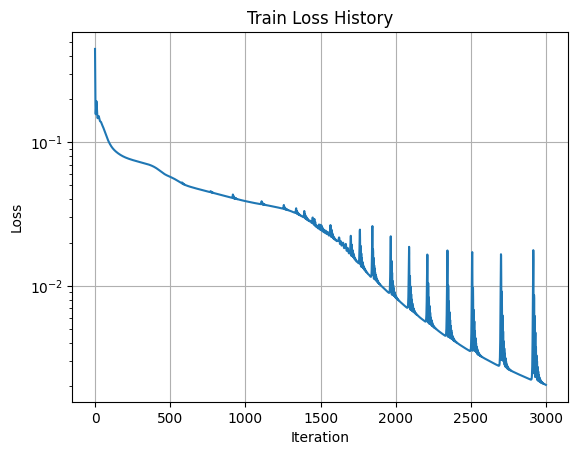

In [15]:
max_num = 3000
agent = PINN()
agent.train(max_num)

In [21]:
np.linspace(-1, 1, 300).shape

(300,)

Shape:  (90000, 1)


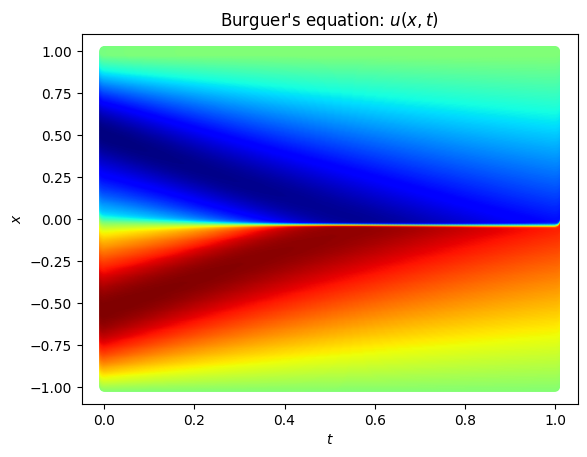

In [23]:
# test
x_test = np.linspace(-1, 1, 300)
t_test = np.linspace(0, 1, 300)
xt_test = []
u_test = []

for x in x_test:
    for t in t_test:
        xt_test.append([x, t])
        u_test.append([0])

xt_test = np.array(xt_test)
u_test = np.array(u_test)

u_pred = agent.predict(tf.convert_to_tensor(xt_test, dtype=tf.float32))
u_pred = u_pred.numpy()
print("Shape: ", u_pred.shape)
u_pred = u_pred.reshape(300, 300)

plt.figure()
plt.scatter(xt_test[:, 1], xt_test[:, 0], c=u_pred, cmap="jet")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title("Burguer's equation: $u(x,t)$")
plt.show()

In [ ]:
def burgers_data():
    # set number of data points
    N_b = 500 # boundary
    N_t = 500 # initial time
    N_c = 20000 # collocation point

    # set boundary
    xmin, xmax = -1.0, 1.0
    tmin, tmax = 0.0, 1.0

    # initial condition
    initial_xt = np.linspace([xmin, tmin], [xmax, tmin], N_t)
    initial_u = -np.sin(np.pi * initial_xt[:, 0]).reshape(-1, 1)

    # boundary condition
    boundary_up = np.linspace([xmax, tmin], [xmax, tmax], N_b)
    boundary_up_sol = np.zeros((N_b, 1))
    boundary_down = np.linspace([xmin, tmin], [xmin, tmax], N_b)
    boundary_down_sol = np.zeros((N_b, 1))

    # collection of initial and boundary condition
    xt_bnd = np.concatenate([initial_xt, boundary_up, boundary_down], axis=0)
    u_bnd_sol = np.concatenate([initial_u, boundary_up_sol, boundary_down_sol], axis=0)

    # collocation point
    t_col_data = np.random.uniform(tmin, tmax, [N_c, 1])
    x_col_data = np.random.uniform(xmin, xmax, [N_c, 1])
    xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
    xt_col = np.concatenate([xt_col_data, xt_bnd], axis=0)

    # convert all to tensors
    xt_col = tf.convert_to_tensor(xt_col, dtype=tf.float32)
    xt_bnd = tf.convert_to_tensor(xt_bnd, dtype=tf.float32)
    u_bnd_sol = tf.convert_to_tensor(u_bnd_sol, dtype=tf.float32)

    return xt_col, xt_bnd, u_bnd_sol

In [ ]:
class Burgers(Model):

    def __init__(self):
        super(Burgers, self).__init__()

        self.h1 = Dense(20, activation="tanh")
        self.h2 = Dense(20, activation="tanh")
        self.h3 = Dense(20, activation="tanh")
        self.h4 = Dense(20, activation="tanh")
        self.h5 = Dense(20, activation="tanh")
        self.h6 = Dense(20, activation="tanh")
        self.u = Dense(1, activation="linear")

    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        x = self.h6(x)
        out = self.u(x)
        return out


class PINN:
    def __init__(self):
        self.lr = 0.001
        self.opt = Adam(self.lr)
        self.model = Burgers()
        self.model.build(input_shape=(None, 2))

        self.train_loss_history = []
        self.iter_count = 0
        self.instant_loss = 0

    @tf.function
    def physics_net(self, xt):
        x = xt[:, 0:1]
        t = xt[:, 1:2]
        xt_t = tf.concat([x, t], axis=1)
        u = self.model(xt_t)
        u_x = tf.gradient(u, x)
        u_xx = tf.gradient(u_x, x)
        u_t = tf.gradient(u, t)

        f = u_t + u * u_x - (0.01 / tf.constant(np.pi)) * u_xx
        return f

    def save_weights(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        self.model.save_weights(path + "burgers.h5")

    def load_weights(self, path):
        self.model.load_weights(path + "burgers.h5")

    def compute_loss(self, f, u_bnd_hat, u_bnd_sol):
        loss_col = tf.reduce_mean(tf.square(f))
        loss_bnd = tf.reduce_mean(tf.square(u_bnd_hat - u_bnd_sol))

        loss = loss_col + loss_bnd

        return loss

    def compute_grad(self, xt_col, xt_bnd, u_bnd_sol):
        with tf.GradientTape() as tape:
            f = self.physics_net(xt_col)
            u_bnd_hat = self.model(xt_bnd)

            loss = self.compute_loss(f, u_bnd_hat, u_bnd_sol)

        grads = tape.gradient(loss, self.model.trainable_variables)

        return loss, grads

    def callback(self, arg=None):
        if self.iter_count % 100 == 0:
            print("Iter: %d, Loss: %.4e" % (self.iter_count, self.instant_loss))
            self.train_loss_history.append([self.iter_count, self.instant_loss])
        self.iter_count += 1

    def learn(self, xt_col, xt_bnd, u_bnd_sol):
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss

    def predict(self, xt):
        return self.model(xt)

    def train_lbfgs(self, xt_col, xt_bnd, u_bnd_sol):
        return scipy.optimize.minimize(fun=loss_grad,
                                       x0=w0,
                                       jac=True,
                                       method="L-BFGS-B",
                                       callback=self.callback,
                                       options={"maxiter": 3000,
                                                "maxfun": 50000,
                                                "maxcor": 50,
                                                "maxls": 50,
                                                "ftol": 1.0 * np.finfo(float).eps})

    def train(self, max_num):
        xt_col, xt_bnd, u_bnd_sol = burgers_data()

        for iter in range(int(max_num)):
            loss = self.learn(
                tf.convert_to_tensor(xt_col_data, dtype=tf.float32),
                tf.convert_to_tensor(xt_bnd_data, dtype=tf.float32),
                tf.convert_to_tensor(tu_bnd_data, dtype=tf.float32),
            )

        self.save_weights("./save_weights/")

        np.savetxt("./save_weights/train_loss_history.txt", self.train_loss_history)
        self.train_loss_history = np.array(self.train_loss_history)

        plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Train Loss History")
        plt.grid()
        plt.show()

In [ ]:
agent = PINN()
agent.load_weights("./save_weights")

# data for validation
x_input = np.linspace(-1.0, 1.0, 300)
t_input = np.linspace(0.0, 1.0, 300)

x_data = x_input.reshape(-1, 1)

results = []

for t in t_input:
    t_data = t * np.ones(x_data.shape)
    xt_data = np.concatenate([x_data, t_data], axis=1)
    u_pred = agent.predict(tf.convert_to_tensor(xt_data, dtype=tf.float32))
    res = np.concatenate([xt_data, u_pred.numpy()], axis=1)
    results.append(res)

results = np.array(results)
results = results.reshape(-1, 3)

# plotting
plt.figure()
plt.scatter(results[:, 1], results[:, 0], c=results[:, 2], s=1, cmap="jet")
plt.colorbar()
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.title("Burger's equation: $u(x,t)$")
plt.show()